This notebook is necessary for the metabolic network visualization

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Map-top-quantities-to-pathways" data-toc-modified-id="Map-top-quantities-to-pathways-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Map top quantities to pathways</a></span><ul class="toc-item"><li><span><a href="#16S-KEGGs" data-toc-modified-id="16S-KEGGs-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>16S KEGGs</a></span></li><li><span><a href="#Shotgun-KEGGs" data-toc-modified-id="Shotgun-KEGGs-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Shotgun KEGGs</a></span></li><li><span><a href="#RNAseq-KEGGs" data-toc-modified-id="RNAseq-KEGGs-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>RNAseq KEGGs</a></span></li><li><span><a href="#Summarize-pathway-information" data-toc-modified-id="Summarize-pathway-information-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Summarize pathway information</a></span></li></ul></li><li><span><a href="#Map-KEGGs-to-compounds" data-toc-modified-id="Map-KEGGs-to-compounds-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Map KEGGs to compounds</a></span><ul class="toc-item"><li><span><a href="#16S" data-toc-modified-id="16S-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>16S</a></span></li><li><span><a href="#WGS" data-toc-modified-id="WGS-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>WGS</a></span></li><li><span><a href="#RNAseq" data-toc-modified-id="RNAseq-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>RNAseq</a></span></li></ul></li></ul></div>

In [1]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import biom
import arviz as az
from scipy.spatial.distance import euclidean
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials)
from plot import (rankplot, networkplot, vectorplot)
import random

# directory paths
amp_directory = '../sfari/data/sra/Combined'
wgs_directory = '../sfari/data/sra_shotgun/Combined'
rna_directory = '../sfari/data/recount3'
kang_directory = '../sfari/data/sra/Kang2017'
sepp_directory = '../sfari/data/sra/Kang2017/deblur/sepp'
results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

In [2]:
# load 16S, whole genome shotgun and RNAseq data
posterior_name = os.path.join('age_sex_matched_posterior',
                              'differential_posterior.nc')
amp_fname = f'{amp_directory}/{posterior_name}'
wgs_fname = f'{wgs_directory}/{posterior_name}'
rna_fname = f'{rna_directory}/{posterior_name}'
amp_diffs = extract_differentials(amp_fname)
wgs_diffs = extract_differentials(wgs_fname)
rna_diffs = extract_differentials(rna_fname)

# Compute statistical tests for each data layer
# Here, we will only focus on the top 5% of the features
amp_stats = ranking(amp_diffs, reference_percentile=95)
wgs_stats = ranking(wgs_diffs, reference_percentile=95)
rna_stats = ranking(rna_diffs, reference_percentile=95)

# Map top quantities to pathways

We will take the taxa and transcripts that passed the thresholds and map them to KEGGs
1. For 16S, we will pull out Picrust annotations and use a binomial test to perform a comparative genomics analysis
2. For shotgun, we will use the Woltka stratification and apply the same binomial test
3. For RNAseq, we will map Ensembl ids to Uniprot and then KEGG

## 16S KEGGs

In [3]:
# Perform binomial test on 16S data to determine uniquely identifying genes
amp_con, amp_asd = select_features(amp_stats, alpha=0.1)
ko_amp = pd.read_table(f'{amp_directory}/picrust2_out_pipeline/KO_predicted.tsv', 
                       index_col=0)
kegg_con_amp = ko_amp.align(amp_con, axis=0, join='inner')[0]
kegg_asd_amp = ko_amp.align(amp_asd, axis=0, join='inner')[0]
# apply binomial test.  Use BH correction to get per-gene pvalues
kegg_con_amp, kegg_asd_amp = btest(kegg_con_amp, kegg_asd_amp)
kegg_asd_amp = log_pvalue(kegg_asd_amp, alpha=0.1)

sig_amp = aggregate_pathways(
    pathway_name_file=f'{kegg_dir}/pathway_name.txt',
    pathway_to_ko_file=f'{kegg_dir}/pathway-to-ko.txt',
    features=kegg_asd_amp
)

## Shotgun KEGGs

In [4]:
# Perform binomial test on shotgun metagenomics data
# Place hard threshold to select top ASD associated microbes
# Obtain presence-absence tables of microbes and their 
# corresponding KEGG genes in the shotgun data
wgs_con, wgs_asd = select_features(wgs_stats, alpha=0.1)
ko_ogu = get_genomic_data(f'{wgs_directory}/table_func.biom')
kegg_con_wgs = ko_ogu.align(wgs_con, axis=0, join='inner')[0]
kegg_asd_wgs = ko_ogu.align(wgs_asd, axis=0, join='inner')[0]

kegg_con_wgs, kegg_asd_wgs = btest(kegg_con_wgs, kegg_asd_wgs)
kegg_asd_wgs = log_pvalue(kegg_asd_wgs, alpha=0.1)
# apply binomial test.  Use BH correction to get per-gene pvalues
sig_wgs = aggregate_pathways(
    pathway_name_file=f'{kegg_dir}/pathway_name.txt',
    pathway_to_ko_file=f'{kegg_dir}/pathway-to-ko.txt',
    features=kegg_asd_wgs
)

## RNAseq KEGGs

In [23]:
# Visualize KEGG counts for RNAseq data 
rna_con, rna_asd = select_features(rna_stats)
fname = f'{rna_directory}/ensembl2kegg.txt'
ensembl2ko = pd.read_table(fname, index_col=0)
ensembl2ko = ensembl2ko.set_index('gene_stable_id')
rna_asd = collapse_transcripts(rna_asd)
kegg_asd_rna = pd.merge(ensembl2ko, rna_asd, 
                        left_index=True, right_index=True)
kegg_asd_rna = kegg_asd_rna[['KO', 'pvalue']]
kegg_asd_rna = kegg_asd_rna.groupby('KO').mean()
kegg_asd_rna = log_pvalue(kegg_asd_rna, alpha=0.1)
split_func = lambda x: x.split(':')[-1]
#kegg_asd_rna['HSA'] = kegg_asd_rna['KEGG']
kegg_asd_rna['KEGG'] = kegg_asd_rna['KEGG'].apply(split_func)

sig_rna = aggregate_pathways(
    pathway_name_file=f'{hsa_dir}/pathway_name.txt',
    pathway_to_ko_file=f'{hsa_dir}/ko-to-pathway.txt',
    features=kegg_asd_rna,
    columns=['HSA', 'Pathway']
)

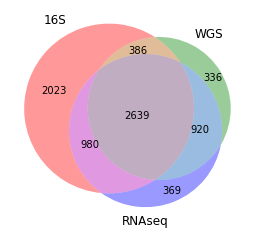

In [6]:
# Venn diagram to visualize overlap
venn3([set(kegg_asd_amp.index), 
       set(kegg_asd_wgs.index), 
       set(kegg_asd_rna.index)], 
      set_labels=['16S', 'WGS', 'RNAseq'])

## Summarize pathway information

In [7]:
df1 = pd.DataFrame(kegg_asd_amp, columns=['KEGG'])
df2 = pd.DataFrame(kegg_asd_wgs, columns=['KEGG'])
df3 = pd.DataFrame(kegg_asd_rna, columns=['KEGG'])
df1['TYPE'] = '16S'
df2['TYPE'] = 'Shotgun'
df3['TYPE'] = 'RNAseq'
sig_keggs = pd.concat((df1, df2, df3), axis=0)

In [8]:
sig_keggs = sig_keggs.rename(columns={'KEGG': '#KEGG'})
sig_keggs.to_csv('../results/WGS_16S_RNAseq_keggs.txt', sep='\t', index=None)

# Map KEGGs to compounds

## 16S

In [9]:
kegg_dir = '../results/kegg'
pwy2kegg = read_kegg_dict(f'{kegg_dir}/pathway-to-ko.txt', 
                          ['Pathway', 'KO'])

pwy_name = pd.read_table(f'{kegg_dir}/pathway_name.txt', header=None)
pwy_name.columns = ['Pathway', 'Name']
pwy2kegg = pd.merge(pwy2kegg, pwy_name, left_on='Pathway', right_on='Pathway')

lookup = {d: i for i, d in enumerate(pwy2kegg['Name'].value_counts().index)}
pwy2kegg['ID'] = pwy2kegg['Name'].apply(lambda x: lookup[x])

sig_16S = kegg_asd_amp
sig_16S = pd.merge(pwy2kegg, sig_16S, left_on='KO', right_on='KEGG').drop_duplicates()
pwy2kegg = pwy2kegg.set_index('Pathway')

pwy2compound = read_kegg_dict(f'{kegg_dir}/pathway-to-compound.txt', 
                              ['Pathway', 'Compound'])
sig_16S = pd.merge(sig_16S, pwy2compound, left_on='Pathway', right_on='Pathway')
sig_16S.to_csv('../results/16S_compounds.csv')

## WGS

In [10]:
kegg_dir = '../results/kegg'

pwy2kegg = read_kegg_dict(f'{kegg_dir}/pathway-to-ko.txt', 
                          ['Pathway', 'KO'])

pwy_name = pd.read_table(f'{kegg_dir}/pathway_name.txt', header=None)
pwy_name.columns = ['Pathway', 'Name']
pwy2kegg = pd.merge(pwy2kegg, pwy_name, left_on='Pathway', right_on='Pathway')

lookup = {d: i for i, d in enumerate(pwy2kegg['Name'].value_counts().index)}
pwy2kegg['ID'] = pwy2kegg['Name'].apply(lambda x: lookup[x])

sig_WGS = pd.merge(pwy2kegg, kegg_asd_wgs, left_on='KO', right_on='KEGG').drop_duplicates()
pwy2kegg = pwy2kegg.set_index('Pathway')

pwy2compound = read_kegg_dict(f'{kegg_dir}/pathway-to-compound.txt', 
                              ['Pathway', 'Compound'])
sig_WGS = pd.merge(sig_WGS, pwy2compound, left_on='Pathway', right_on='Pathway')
sig_WGS.to_csv('../results/WGS_compounds.csv')

## RNAseq

In [56]:
hsa_dir = '../results/hsa_kegg'

pwy2kegg = read_kegg_dict(f'{hsa_dir}/ko-to-pathway.txt', 
                          ['HSA', 'Pathway'])

pwy_name = pd.read_table(f'{hsa_dir}/pathway_name.txt', header=None)
pwy_name.columns = ['Pathway', 'Name']
pwy2kegg = pd.merge(pwy2kegg, pwy_name, left_on='Pathway', right_on='Pathway')
lookup = {d: i for i, d in enumerate(pwy2kegg['Name'].value_counts().index)}
pwy2kegg['ID'] = pwy2kegg['Name'].apply(lambda x: lookup[x])
pwy2kegg = pwy2kegg.set_index('Pathway')

sig_RNA = pd.merge(pwy2kegg, sig_rna, left_on='HSA', right_on='HSA').drop_duplicates()
 
pwy2compound = read_kegg_dict(f'{hsa_dir}/pathway-to-compound.txt', 
                              ['Pathway', 'Compound'])
sig_RNA = pd.merge(sig_RNA, pwy2compound, left_on='Pathway', right_on='Pathway')
sig_RNA.to_csv('../results/RNA_compounds.csv')

In [57]:
sig_RNA

,HSA,Name_x,ID_x,Pathway,Name_y,ID_y,KEGG,pvalue,-log(pvalue),pvalue_corrected,Compound
0,100,Purine metabolism - Homo sapiens (human),89,hsa00230,Purine metabolism - Homo sapiens (human),89,100,1.274538e-200,459.695242,1.360172e-200,C00002
1,100,Purine metabolism - Homo sapiens (human),89,hsa00230,Purine metabolism - Homo sapiens (human),89,100,1.274538e-200,459.695242,1.360172e-200,C00008
2,100,Purine metabolism - Homo sapiens (human),89,hsa00230,Purine metabolism - Homo sapiens (human),89,100,1.274538e-200,459.695242,1.360172e-200,C00011
3,100,Purine metabolism - Homo sapiens (human),89,hsa00230,Purine metabolism - Homo sapiens (human),89,100,1.274538e-200,459.695242,1.360172e-200,C00014
4,100,Purine metabolism - Homo sapiens (human),89,hsa00230,Purine metabolism - Homo sapiens (human),89,100,1.274538e-200,459.695242,1.360172e-200,C00020
...,...,...,...,...,...,...,...,...,...,...,...
1197604,9986,Terpenoid backbone biosynthesis - Homo sapiens...,328,hsa00900,Terpenoid backbone biosynthesis - Homo sapiens...,328,9986,0.000000e+00,460.517019,0.000000e+00,C20120
1197605,9986,Terpenoid backbone biosynthesis - Homo sapiens...,328,hsa00900,Terpenoid backbone biosynthesis - Homo sapiens...,328,9986,0.000000e+00,460.517019,0.000000e+00,C20121
1197606,9986,Terpenoid backbone biosynthesis - Homo sapiens...,328,hsa00900,Terpenoid backbone biosynthesis - Homo sapiens...,328,9986,0.000000e+00,460.517019,0.000000e+00,C20345
1197607,9986,Terpenoid backbone biosynthesis - Homo sapiens...,328,hsa00900,Terpenoid backbone biosynthesis - Homo sapiens...,328,9986,0.000000e+00,460.517019,0.000000e+00,C20847


In [34]:
sig_RNA

,HSA,Pathway_x,Name_x,ID_x,Pathway_y,Name_y,ID_y,KEGG,pvalue,-log(pvalue),pvalue_corrected
0,100,hsa00230,Purine metabolism - Homo sapiens (human),89,hsa00230,Purine metabolism - Homo sapiens (human),89,100,1.274538e-200,459.695242,1.360172e-200
1,100,hsa00230,Purine metabolism - Homo sapiens (human),89,hsa01100,Metabolic pathways - Homo sapiens (human),0,100,1.274538e-200,459.695242,1.360172e-200
2,100,hsa00230,Purine metabolism - Homo sapiens (human),89,hsa05340,Primary immunodeficiency - Homo sapiens (human),247,100,1.274538e-200,459.695242,1.360172e-200
3,100,hsa01100,Metabolic pathways - Homo sapiens (human),0,hsa00230,Purine metabolism - Homo sapiens (human),89,100,1.274538e-200,459.695242,1.360172e-200
4,100,hsa01100,Metabolic pathways - Homo sapiens (human),0,hsa01100,Metabolic pathways - Homo sapiens (human),0,100,1.274538e-200,459.695242,1.360172e-200
...,...,...,...,...,...,...,...,...,...,...,...
111057,9953,hsa00534,Glycosaminoglycan biosynthesis - heparan sulfa...,303,hsa00534,Glycosaminoglycan biosynthesis - heparan sulfa...,303,9953,0.000000e+00,460.517019,0.000000e+00
111058,9955,hsa00534,Glycosaminoglycan biosynthesis - heparan sulfa...,303,hsa00534,Glycosaminoglycan biosynthesis - heparan sulfa...,303,9955,0.000000e+00,460.517019,0.000000e+00
111059,4166,hsa00533,Glycosaminoglycan biosynthesis - keratan sulfa...,333,hsa00533,Glycosaminoglycan biosynthesis - keratan sulfa...,333,4166,0.000000e+00,460.517019,0.000000e+00
111060,90353,hsa04122,Sulfur relay system - Homo sapiens (human),313,hsa04122,Sulfur relay system - Homo sapiens (human),313,90353,0.000000e+00,460.517019,0.000000e+00


In [32]:
pwy2kegg.sort_index()

,HSA,Name,ID
Pathway,,,
ko00010,K00001,Glycolysis / Gluconeogenesis,16
ko00010,K01689,Glycolysis / Gluconeogenesis,16
ko00010,K01785,Glycolysis / Gluconeogenesis,16
ko00010,K01792,Glycolysis / Gluconeogenesis,16
ko00010,K01803,Glycolysis / Gluconeogenesis,16
...,...,...,...
ko05418,K00510,Fluid shear stress and atherosclerosis,136
ko05418,K00355,Fluid shear stress and atherosclerosis,136
ko05418,K01940,Fluid shear stress and atherosclerosis,136


In [27]:
sig_rna

,HSA,Pathway,Name,ID,KEGG,pvalue,-log(pvalue),pvalue_corrected
0,100,hsa00230,Purine metabolism - Homo sapiens (human),89,100,1.274538e-200,459.695242,1.360172e-200
1,100,hsa01100,Metabolic pathways - Homo sapiens (human),0,100,1.274538e-200,459.695242,1.360172e-200
2,100,hsa05340,Primary immunodeficiency - Homo sapiens (human),247,100,1.274538e-200,459.695242,1.360172e-200
3,10606,hsa00230,Purine metabolism - Homo sapiens (human),89,10606,0.000000e+00,460.517019,0.000000e+00
4,10606,hsa01100,Metabolic pathways - Homo sapiens (human),0,10606,0.000000e+00,460.517019,0.000000e+00
...,...,...,...,...,...,...,...,...
7931,9953,hsa00534,Glycosaminoglycan biosynthesis - heparan sulfa...,303,9953,0.000000e+00,460.517019,0.000000e+00
7932,9955,hsa00534,Glycosaminoglycan biosynthesis - heparan sulfa...,303,9955,0.000000e+00,460.517019,0.000000e+00
7933,4166,hsa00533,Glycosaminoglycan biosynthesis - keratan sulfa...,333,4166,0.000000e+00,460.517019,0.000000e+00
7934,90353,hsa04122,Sulfur relay system - Homo sapiens (human),313,90353,0.000000e+00,460.517019,0.000000e+00


In [17]:
pwy2compound 

,Pathway,Compound
0,hsa00010,C00022
1,hsa00010,C00024
2,hsa00010,C00031
3,hsa00010,C00033
4,hsa00010,C00036
...,...,...
5847,hsa05418,C00533
5848,hsa05418,C00607
5849,hsa05418,C00704
5850,hsa05418,C00925


In [15]:
kegg_asd_rna

,KEGG,pvalue,-log(pvalue),pvalue_corrected,HSA
0,100,1.274538e-200,459.695242,1.360172e-200,hsa:100
1,10002,0.000000e+00,460.517019,0.000000e+00,hsa:10002
2,10004,0.000000e+00,460.517019,0.000000e+00,hsa:10004
3,100049587,7.625774e-287,460.517019,8.271227e-287,hsa:100049587
4,100101467,0.000000e+00,460.517019,0.000000e+00,hsa:100101467
...,...,...,...,...,...
4903,997,0.000000e+00,460.517019,0.000000e+00,hsa:997
4904,9973,0.000000e+00,460.517019,0.000000e+00,hsa:9973
4905,9984,0.000000e+00,460.517019,0.000000e+00,hsa:9984
4906,9986,0.000000e+00,460.517019,0.000000e+00,hsa:9986


In [16]:
pwy2kegg

,HSA,Name,ID
Pathway,,,
ko00010,K00001,Glycolysis / Gluconeogenesis,16
ko00010,K00002,Glycolysis / Gluconeogenesis,16
ko00010,K00016,Glycolysis / Gluconeogenesis,16
ko00010,K00121,Glycolysis / Gluconeogenesis,16
ko00010,K00128,Glycolysis / Gluconeogenesis,16
...,...,...,...
ko05135,K13735,Yersinia infection,276
ko00965,K15777,Betalain biosynthesis,292
ko00365,K16874,Furfural degradation,205
